In [12]:
# !pip install plotly
# !pip install pandas
import pandas as pd
# !pip install pandas_ta
# import pandas_ta as ta
import numpy as np
# !pip install seaborn
import seaborn as sns
import datetime
from datetime import timedelta
import math
import requests
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt


import sklearn as sk
import sklearn.preprocessing
from sklearn import metrics
from matplotlib.pyplot import figure

from sklearn.preprocessing import  (StandardScaler, MinMaxScaler, LabelBinarizer)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb
from sklearn.metrics import *
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# !pip install keras
# !pip install tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

# !pip install graphviz
# import graphviz
# import chart_studio.tools as tls

# Creating DataFrame

In [13]:
#manipulatable variables
numDaysBack = str(365*5) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['avalanche-2'] #can add more than one coin if you like
baseCoin = theCoins[0]
window_length = 14
mycom = 0.4
lower_macd_ema = 12
upper_macd_ema = 26
trigger_macd_ema = 9


def df_builder_clean(days, interval, coins):
    #manipulatable variables
    numDaysBack = days #for daily you can go back multiple years worth, for daily you can only go back 90 days
    myInterval = interval # options are daily or hourly
    theCoins = coins

    #builds initial dataframe with ethereum as first market but just to log the dates we are working with
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+baseCoin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    ts = ts/1000
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        currentUnix = currentUnix/1000
#         currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S") #adding dd-mm-yyyy hours minutes seconds
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y") #just the date mm-dd-yyyy
        HistPricesList.append([currentTS])
    global df
    df = pd.DataFrame(HistPricesList, columns = ['date'])

    
    #looping through each coin and adding in all data points and input variables
    for coin in theCoins:
        price_data(coin)
#         add_ewm(coin, mycom)
#         add_rsi(coin, window_length)
#         add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
        print('just added: ', coin)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
#     print('r')
#     display(r)
    return df


def price_data(coin):
    global df
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%m-%d-%Y"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['date', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    df = pd.merge(df, dfCoin[coin], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    df = pd.merge(df, dfCoin[coin+'_volume'], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    
def add_ewm(coin, mycom):
    df[coin+'_ewm'] = df[coin].ewm(com=mycom).mean()
    
def add_rsi(coin, window_length):
    global df
    df['diff'] = df[coin].diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
        
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    df = pd.DataFrame(df)
    df = df.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    df.rename(columns=dict,
              inplace=True)

def add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    global df
    #get ema for lower
    k = df[coin].ewm(span=lower_macd_ema, adjust = False, min_periods = lower_macd_ema).mean()

    #get ema for upper
    d = df[coin].ewm(span=upper_macd_ema, adjust=False, min_periods=upper_macd_ema).mean()

    macd = k-d
    
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=trigger_macd_ema, adjust=False, min_periods=trigger_macd_ema).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_h)
    df['macd_s'] = df.index.map(macd_s)



mydf = pd.DataFrame(df_builder_clean(numDaysBack, myInterval, theCoins))
display(mydf)



09-21-2020
just added:  avalanche-2


,avalanche-2,avalanche-2_volume
date,,
2020-09-21,5.284244,2.458573e+08
2020-09-22,5.284244,2.458573e+08
2020-09-23,3.491229,9.734243e+07
2020-09-24,4.573891,6.966517e+07
2020-09-25,4.702974,4.195075e+07
...,...,...
2022-08-27,20.159519,2.788035e+08
2022-08-28,18.502139,3.112881e+08
2022-08-29,19.394373,5.236042e+08


In [14]:
mydf.dropna(inplace=True)
# myCols = ['ethereum', 'ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']

In [15]:
my_data = mydf
display(my_data.tail(10))
# my_data.drop(my_data.tail(10).index,
#         inplace = True)
display(my_data)

,avalanche-2,avalanche-2_volume
date,,
2022-08-22,22.578587,4.797824e+08
2022-08-23,23.569158,4.265656e+08
2022-08-24,23.037001,3.079918e+08
2022-08-25,23.073552,2.708273e+08
2022-08-26,20.624684,4.156800e+08
2022-08-27,20.159519,2.788035e+08
2022-08-28,18.502139,3.112881e+08
2022-08-29,19.394373,5.236042e+08
2022-08-30,19.346257,5.201622e+08


,avalanche-2,avalanche-2_volume
date,,
2020-09-21,5.284244,2.458573e+08
2020-09-22,5.284244,2.458573e+08
2020-09-23,3.491229,9.734243e+07
2020-09-24,4.573891,6.966517e+07
2020-09-25,4.702974,4.195075e+07
...,...,...
2022-08-27,20.159519,2.788035e+08
2022-08-28,18.502139,3.112881e+08
2022-08-29,19.394373,5.236042e+08


Train Test Split

# 60 day sliding window predictions

In [16]:
# def build_sliding_df(window, mydf, baseCoin):
    
#     seq=list(mydf[baseCoin])
#     # display(seq)
#     scaler = StandardScaler()
#     window_size = 15
#     sliding_window=[]
#     for i in range(len(seq) - window_size + 1):
#         sliding_window.append(seq[i: i + window_size])

#     # print(sliding_window)

#     sliding_df = pd.DataFrame(sliding_window)

#     sliding_df = sliding_df.drop(columns=[1,2,3,4,5])
#     display(sliding_df)


seq=list(mydf[baseCoin])
# display(seq)
scaler = StandardScaler()
window_size = 15
sliding_window=[]
for i in range(len(seq) - window_size + 1):
    sliding_window.append(seq[i: i + window_size])
    
# print(sliding_window)

sliding_df = pd.DataFrame(sliding_window)

sliding_df = sliding_df.drop(columns=[1,2,3,4,5])
display(sliding_df)
y = sliding_df[14]
X = sliding_df.drop(columns=[14]) 
X=scaler.fit_transform(X)
# print('X')
# display(X)
# print('y')
# display(y)
# X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
X_train = X[:-360]
X_test = X[-360:]
y_train = y[:-360]
y_test = y[-360:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)


,0,6,7,8,9,10,11,12,13,14
0,5.284244,4.652980,4.206659,4.138615,4.327332,4.155603,3.909910,4.028154,3.968853,3.983027
1,5.284244,4.206659,4.138615,4.327332,4.155603,3.909910,4.028154,3.968853,3.983027,3.541747
2,3.491229,4.138615,4.327332,4.155603,3.909910,4.028154,3.968853,3.983027,3.541747,3.441365
3,4.573891,4.327332,4.155603,3.909910,4.028154,3.968853,3.983027,3.541747,3.441365,3.908382
4,4.702974,4.155603,3.909910,4.028154,3.968853,3.983027,3.541747,3.441365,3.908382,4.243203
...,...,...,...,...,...,...,...,...,...,...
691,29.143483,22.535468,22.276532,23.063913,22.578587,23.569158,23.037001,23.073552,20.624684,20.159519
692,28.225166,22.276532,23.063913,22.578587,23.569158,23.037001,23.073552,20.624684,20.159519,18.502139
693,27.878861,23.063913,22.578587,23.569158,23.037001,23.073552,20.624684,20.159519,18.502139,19.394373
694,27.251164,22.578587,23.569158,23.037001,23.073552,20.624684,20.159519,18.502139,19.394373,19.346257


X_train: 
(336, 9)
X_test: 
(360, 9)
y_train: 
(336,)
y_test: 
(360,)


Root Mean squared error train: 2.46
Root Mean squared error test: 4.61
r2_score train:  0.9658269360007641
r2_score test:  0.9778161724479683
adjusted r2_score test: 0.9772457311680589


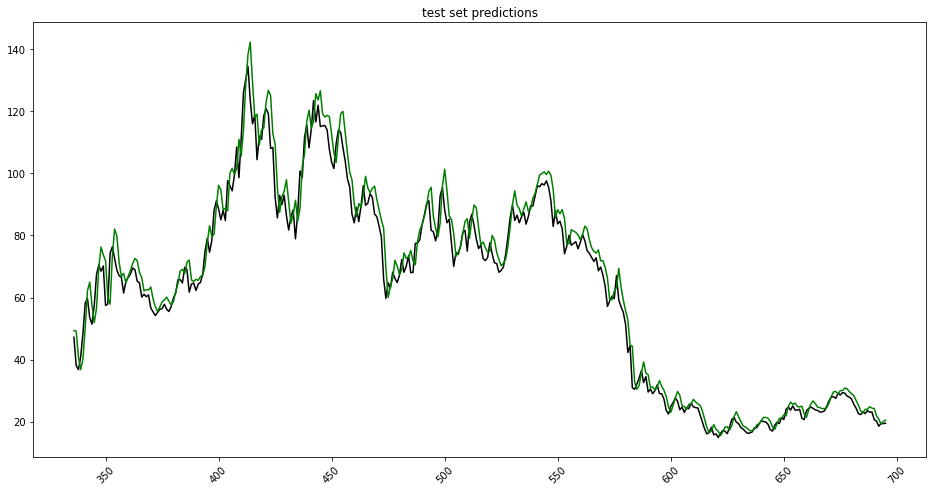

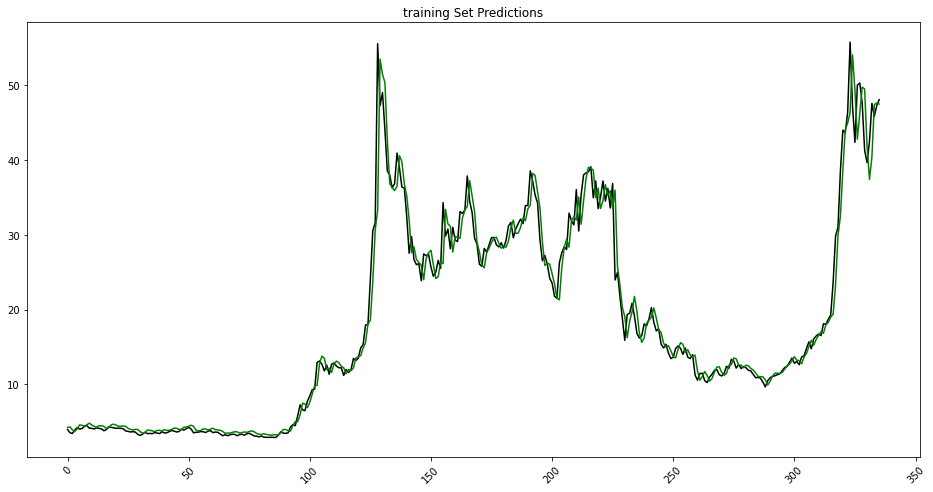

In [17]:
# print('linear regression with no scaling')
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_test = regr.predict(X_test)
y_pred_train = regr.predict(X_train)
# The mean squared error
# print("Root Mean squared error: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred)))

print("Root Mean squared error train: %.2f" % math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Root Mean squared error test: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred_test)))

print('r2_score train: ', r2_score(y_train, y_pred_train))
print('r2_score test: ', r2_score(y_test, y_pred_test))
print('adjusted r2_score test:', 1-(1-r2_score(y_test, y_pred_test))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))

y_testc = pd.DataFrame(y_test)
# print(y_check1)
y_testc['pred_linear_reg']= y_pred_test*1.047
# print(y_check1)
figure(figsize=(16, 8))
plt.plot(y_testc.index,y_testc[14], color = 'black')
plt.plot(y_testc.index,y_testc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('test set predictions')
plt.show()


y_trainc = pd.DataFrame(y_train)
# print(y_check1)
y_trainc['pred_linear_reg']= y_pred_train
# print(y_check1)
figure(figsize=(16, 8))
plt.plot(y_trainc.index,y_trainc[14], color = 'black')
plt.plot(y_trainc.index,y_trainc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('training Set Predictions')

plt.show()

In [18]:
display(y_testc)
validation = pd.DataFrame(y_testc)
validation =validation.rename(columns={14: baseCoin, 'pred_linear_reg': 'Predictions_test'})
display(validation)

,14,pred_linear_reg
336,47.218804,49.353615
337,38.101679,49.165004
338,36.744571,40.871760
339,40.953329,36.757196
340,48.435666,40.263394
...,...,...
691,20.159519,21.891140
692,18.502139,20.802870
693,19.394373,19.206308
694,19.346257,20.032988


,avalanche-2,Predictions_test
336,47.218804,49.353615
337,38.101679,49.165004
338,36.744571,40.871760
339,40.953329,36.757196
340,48.435666,40.263394
...,...,...
691,20.159519,21.891140
692,18.502139,20.802870
693,19.394373,19.206308
694,19.346257,20.032988


In [19]:
# buy when prediction is below price, and sell when prediction is above price
# validation['buy'] = if validation[baseCoin] > validation['Predictions']

moneyStart = 1000
money = moneyStart
coin = money/validation[baseCoin].iloc[1]



validation['buy'] = np.where(validation[baseCoin] > validation['Predictions_test'], 1, 0)
# validation['sell'] = np.where(validation[baseCoin] < validation['Predictions'], 1, 0)
validation['signal'] = validation['buy'].diff()
validation['money'] = moneyStart

validation = validation.iloc[1:, :]
validation['coin'] = moneyStart/coin
display(validation.head(5))


for index, row in validation.iterrows():
    if row['signal'] == 1:
#         print('buy')
#         print('money: ',  money, 'price: ', row[baseCoin])
        coin = money/row[baseCoin]
        validation.loc[index, 'coin'] = coin
        validation.loc[index, 'money'] = money


        row['coin'] = coin
    elif row['signal'] == -1:
#         print('sell')
        money = coin*row[baseCoin]
        validation.loc[index, 'coin'] = coin
        validation.loc[index, 'money'] = money
    else:
        validation.loc[index, 'coin'] = coin
        validation.loc[index, 'money'] = money
        
display(validation)
#     print(moneyStart/row['Close'])


,avalanche-2,Predictions_test,buy,signal,money,coin
337,38.101679,49.165004,0,0.0,1000,38.101679
338,36.744571,40.871760,0,0.0,1000,38.101679
339,40.953329,36.757196,1,1.0,1000,38.101679
340,48.435666,40.263394,1,0.0,1000,38.101679
341,58.252030,50.313970,1,0.0,1000,38.101679


,avalanche-2,Predictions_test,buy,signal,money,coin
337,38.101679,49.165004,0,0.0,1000.000000,26.245562
338,36.744571,40.871760,0,0.0,1000.000000,26.245562
339,40.953329,36.757196,1,1.0,1000.000000,24.418039
340,48.435666,40.263394,1,0.0,1000.000000,24.418039
341,58.252030,50.313970,1,0.0,1000.000000,24.418039
...,...,...,...,...,...,...
691,20.159519,21.891140,0,0.0,2043.686475,90.514366
692,18.502139,20.802870,0,0.0,2043.686475,90.514366
693,19.394373,19.206308,1,1.0,2043.686475,105.375226
694,19.346257,20.032988,0,-1.0,2038.616167,105.375226


,avalanche-2,Predictions_test,buy,signal,money,coin
337,38.101679,49.165004,0,0.0,1000.000000,26.245562
338,36.744571,40.871760,0,0.0,1000.000000,26.245562
339,40.953329,36.757196,1,1.0,1000.000000,24.418039
340,48.435666,40.263394,1,0.0,1000.000000,24.418039
341,58.252030,50.313970,1,0.0,1000.000000,24.418039
...,...,...,...,...,...,...
691,20.159519,21.891140,0,0.0,2043.686475,90.514366
692,18.502139,20.802870,0,0.0,2043.686475,90.514366
693,19.394373,19.206308,1,1.0,2043.686475,105.375226
694,19.346257,20.032988,0,-1.0,2038.616167,105.375226


number of trades:  89


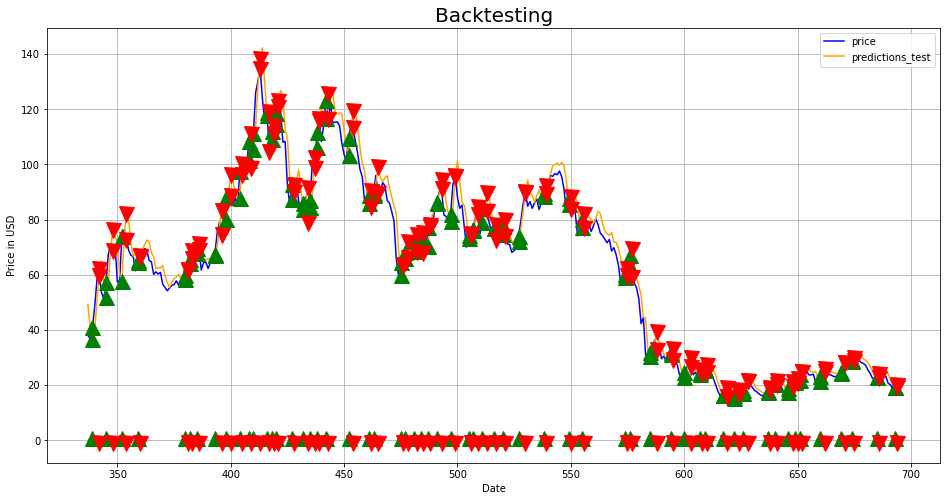

In [20]:
backtest = pd.DataFrame(validation)
display(backtest)
print('number of trades: ', backtest['buy'].sum())
backtest = backtest.drop(columns=(['coin', 'money', 'buy']))
plt.figure(figsize = (16, 8))
backtest[baseCoin].plot(color='blue', label = 'price')
backtest['Predictions_test'].plot(color='orange', label='predictions_test')
plt.plot(backtest[backtest['signal']==1].index, backtest[backtest['signal']==1],'^', markersize = 15, color='g')
plt.plot(backtest[backtest['signal']==-1].index, backtest[backtest['signal']==-1],'v', markersize = 15, color='r')
plt.ylabel('Price in USD')
plt.xlabel('Date')
plt.title('Backtesting', fontsize = 20)
plt.legend()
plt.grid()
plt.show()


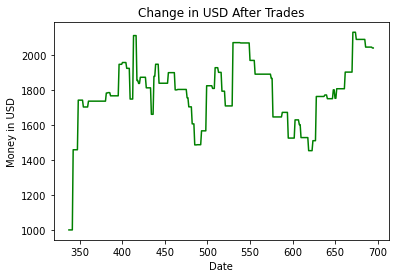

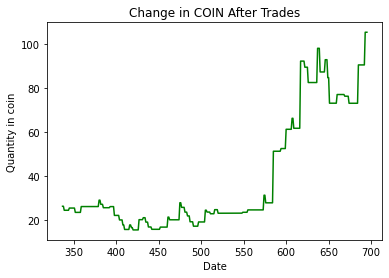

In [21]:
plt.xlabel('Date')
plt.ylabel('Money in USD')
plt.title('Change in USD After Trades')
validation['money'].plot(color='g', label = 'money')
plt.show()

plt.xlabel('Date')
plt.ylabel('Quantity in coin')
plt.title('Change in COIN After Trades')
validation['coin'].plot(color='g', label = 'eth')
plt.show()

In [22]:
display(backtest.tail(15))

,avalanche-2,Predictions_test,signal
681,25.530010,28.344573,0.0
682,24.299012,26.774248,0.0
683,22.535468,25.304915,0.0
684,22.276532,23.397903,0.0
685,23.063913,22.972422,1.0
686,22.578587,23.930773,-1.0
687,23.569158,24.006152,0.0
688,23.037001,24.791809,0.0
689,23.073552,24.334268,0.0
690,20.624684,24.201677,0.0
